In [1]:
import BFast
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 13})

In [2]:
BoxSize = 1000.
kF = 2*np.pi/BoxSize
grid = 256

In [3]:
df = np.load(f"df_m_256_PCS_z=0.npy")

In [4]:
help(BFast.Bk_fast)

Help on function Bk_fast in module BFast.BFast:

Bk_fast(delta, BoxSize, fc, dk, Nbins, triangle_type, MAS=None, verbose=False)
    Computes binned bispectrum of field for given binning and triangles
    
    Parameters:
    -----------
    fc: float
        Center of first bin in units of the fundamental mode.
    dk: float
        Width of the bin in units of the fundamental mode.
    Nbins: int
        Total number of momentum bins such that bins are given by kf*[(fc + i)±dk/2 for i in range(Nbins)].
    triangle_type: str, optional (default='All')
        Type of triangles to include in the bispectrum calculation. 
        Options: 'All' (include all shapes of triangles),
                 'Squeezed' (only triangles k_1 > k_2 = k_3), 
                 'Equilateral' (include only triangles k_1 = k_2 = k_3).
    MAS: str, optional (default=None)
        Mass Assignment Scheme to compensate for (options are NGP,CIC,TSC,PCS)
    verbose: bool, optional (default=False)
        If True, p

In [5]:
%time Bks_fast = BFast.Bk_fast(df,BoxSize,3.,3.,27,'All','PCS',verbose=True)

Loading Counts from BFast_BkCounts_LBox1000_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Considering 2276 Triangle Configurations (All)
CPU times: user 4.59 s, sys: 1.37 s, total: 5.96 s
Wall time: 10 s


In [6]:
%time Bks_fast = BFast.Bk_fast(df,BoxSize,3.,3.,27,'All','PCS',verbose=True)

Loading Counts from BFast_BkCounts_LBox1000_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Considering 2276 Triangle Configurations (All)
CPU times: user 1.07 s, sys: 433 ms, total: 1.5 s
Wall time: 1.43 s


In [7]:
%time Bks = BFast.Bk(df,BoxSize,3.,3.,27,'All','PCS',verbose=True)

Loading Counts from BFast_BkCounts_LBox1000_Grid256_Binning3kF_fc3_NBins27_TriangleTypeAll.npy
Considering 2276 Triangle Configurations (All)
CPU times: user 5.46 s, sys: 4.25 s, total: 9.72 s
Wall time: 10 s


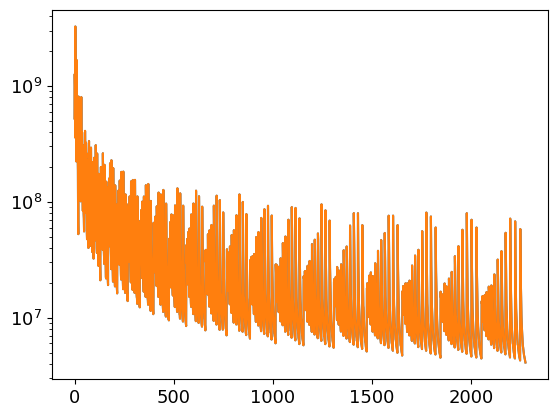

In [8]:
plt.semilogy(Bks_fast[:,-2])
plt.semilogy(Bks[:,-2])

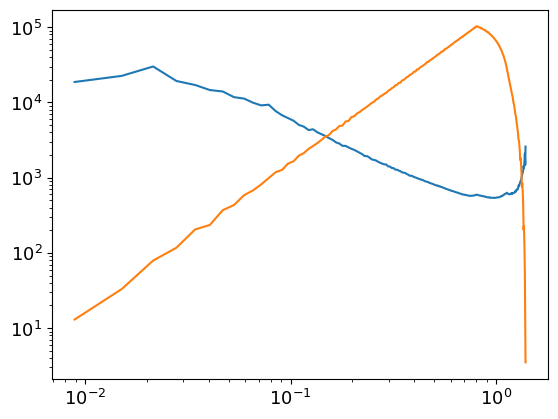

In [10]:
Pks = BFast.Pk(df,1000.,MAS='PCS')

plt.loglog(Pks[:,0],Pks[:,1])
plt.loglog(Pks[:,0],Pks[:,2])